In [1]:
include("C:/Users/mussi/Documents/Manhattan/Leuven/MCQMC/Data_Libraries/1.Libraries_setup.jl")

  Activating project at `C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Data_Libraries`


In [ ]:
forward_model(t, lambda, theta_0, theta_air, t0=0.0) = theta_air .+ (theta_0 - theta_air) .* exp.(-(t .- t0) ./ lambda)

function gibbs_step(t, y, lambda, theta_air, mu0, tau0_sq, a, b, x_prev, u)

    theta0_prev, sigma_sq_prev = x_prev
    t_eff = t[2:end]; y_eff = y[2:end]
    
    phi = exp.(-t_eff ./ lambda)

    # 1) theta0 | sigma_sq, y  ~ Normal(mu_star, tau_star_sq)
    inv_tau_star_sq = 1/tau0_sq + sum(phi.^2) / sigma_sq_prev
    tau_star_sq = 1 / inv_tau_star_sq
    mu_star = tau_star_sq * (mu0/tau0_sq + sum(phi .* (y_eff .- (1 .- phi) .* theta_air)) / sigma_sq_prev)

    theta0_new = mu_star + sqrt(tau_star_sq) * quantile(Normal(), u[1])

    # 2) sigma_sq | theta0, y  ~ InverseGamma(shape, scale)
    res = y_eff .- (phi .* theta0_new .+ (1 .- phi) .* theta_air)
    shape = a + length(t_eff)/2
    scale = b + sum(res.^2)/2

    sigma_sq_new = quantile(InverseGamma(shape, scale), u[2])

    return (theta0_new, sigma_sq_new)
end

function gibbs_ic(t, y; lambda, theta_air, mu0, tau0_sq, a, b,n_iter::Int, burn_in::Int=0, U)

    chain = Array{Float64}(undef, 2, n_iter)
    # Initialisation 
    chain[1, 1] = mu0 + sqrt(tau0_sq) * quantile(Normal(), U[1, 1])
    chain[2, 1] = quantile(InverseGamma(a, b), U[2, 1])

    for k in 2:n_iter
        chain[1, k], chain[2, k] = gibbs_step(t, y, lambda, theta_air, mu0, tau0_sq, a, b, chain[:, k-1], U[:, k])
    end

    chains = chain[:, burn_in+1:end]
    mean_post = vec(mean(chains; dims=2))
    return (chains=chains, mean_post=mean_post)
end


gibbs_ic (generic function with 1 method)

In [193]:
lambda_true    = 1.0      
theta_0_true   = 6.5      # initial lime temperature (°C)
theta_air_true = 25       # air temperature (°C)
sigma_true    = 0.8       # measurement noise std

# Data generation 
Random.seed!(1250) 
t_data = collect(0.0:0.5:10.0)  
theta_true = forward_model(t_data, lambda_true, theta_0_true, theta_air_true)
theta_obs = theta_true .+ rand(Normal(0, sigma_true), length(t_data))

(t_data, theta_obs)

([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5  …  5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0], [5.513187499311, 13.752305129407624, 19.57397929128417, 20.54709468601248, 21.01715908867197, 23.830551987776108, 25.094611696473457, 25.28799686397515, 26.233135353852212, 24.861590384712613  …  23.531520095462874, 24.73413783120096, 23.062149385286347, 26.11175781722477, 25.299784486433833, 23.522568392426795, 25.25060068520779, 25.243969242566163, 25.080980401014067, 25.434258644649713])

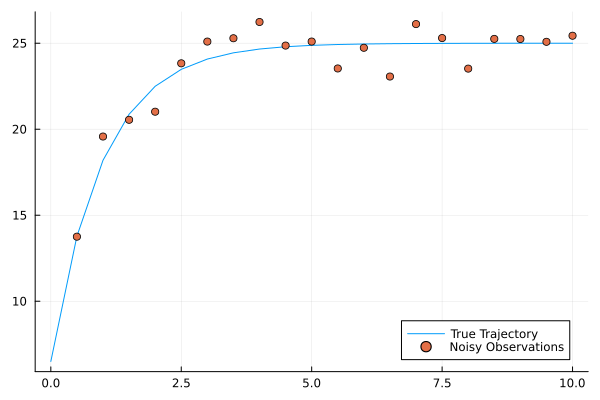

In [194]:
plot(t_data,theta_true, label = "True Trajectory")
scatter!(t_data[2:end], theta_obs[2:end], label= "Noisy Observations")

In [197]:
mu0 = 5; tau0_sq = 5.0    # Hyperparameter for prior on Theta 
a = 2.0; b = 2.0            # Hyperparameter for prior on noise variance 

n_iter = 10000
burn_in = 4000

res = gibbs_ic(t_data, theta_obs; lambda=lambda_true, theta_air=theta_air_true,mu0=mu0, tau0_sq=tau0_sq, a=a, b=b, n_iter=n_iter, burn_in=burn_in, U= rand(2, n_iter))
               
res.mean_post[1]  # stime a posteriori per (theta0, sigma_sq)


6.536130776355332

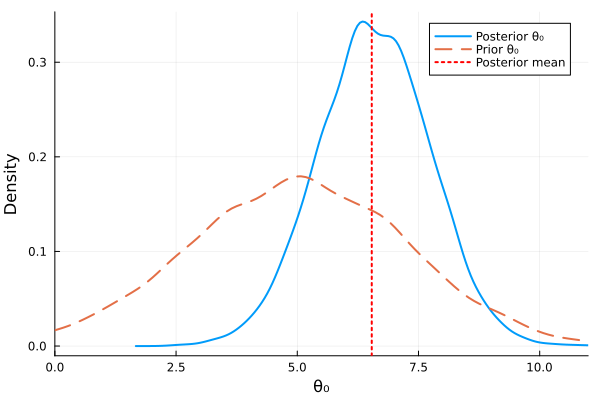

In [198]:
prior_dist = Normal(mu0, sqrt(tau0_sq))
density(res.chains[1, burn_in+1:end]; label="Posterior θ₀", linewidth=2)
density!(rand(prior_dist, 10_000); label="Prior θ₀", linewidth=2, linestyle=:dash, xlims=(0,11))
vline!([res.mean_post[1]]; label="Posterior mean", color=:red, linewidth=2, linestyle=:dot)
xlabel!("θ₀"); ylabel!("Density")

In [ ]:
savefig(iid_sobol_wcud_2, raw"C:\Users\mussi\Documents\Manhattan\Leuven\MCQMC\Plots\gauss_kde_iid_sobol_wcud.png")